# Analysis of Sub-model 3
Homophily based connection

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import itertools
import matplotlib.ticker as mtick
from joblib import Parallel, delayed
import json



In [14]:
from assortativity_model_copy import ConsumatModel

In [16]:
base_config = {
    'TP_percentage': 0.6,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42,  
    'alpha': 10.0, 
    'beta': 0.5,  
    'homophily_attribute': 'preference_conformity'  
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'rewiring_probability': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.3
    }
})

network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

In [17]:
tp_percentages = np.arange(0, 1.05, 0.05)
num_steps = 10
all_results = {network: {} for network in network_configs}
final_adoption_rates = {network: [] for network in network_configs}

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def plot_metric(data, metric, ylabel, filename, scale_as_percentage=False):
    plt.figure(figsize=(15, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

    for color, (tp, df) in zip(colors, data.items()):
        tp_percentage_label = f'{tp * 100:.1f}%'  # Convert TP to percentage for the legend
        if scale_as_percentage:
            plt.plot(df['Step'], df[metric], label=tp_percentage_label, color=color, marker='o')
        else:
            plt.plot(df['Step'], df[metric], label=tp_percentage_label, color=color, marker='o')

    plt.xlabel('Step', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(title='TP Percentage', fontsize=12)
    plt.grid(True)

    if scale_as_percentage:
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    
    plt.savefig(f'assortativitypreference_conformity_{filename}.png')
    plt.close()
    #plt.show()

for network_type, config in network_configs.items():
    for tp in tp_percentages:
        config['TP_percentage'] = tp
        model = ConsumatModel(config)
        model_data = collect_simulation_data(model, num_steps)
        all_results[network_type][tp] = model_data
        final_adoption_rate = model_data['Adoption Rate'].iloc[-1]
        final_adoption_rates[network_type].append(final_adoption_rate)

metrics = [
    ('Adoption Rate', 'Adoption Rate (%)'),
    ('Avg_F_Satisfaction', 'Average Financial Satisfaction'),
    ('Avg_S_Satisfaction', 'Average Social Satisfaction'),
    ('Avg_P_Satisfaction', 'Average Personal Satisfaction'),
    ('Avg_F_Uncertainty', 'Average Financial Uncertainty'),
    ('Avg_S_Uncertainty', 'Average Social Uncertainty'),
    ('Avg_P_Uncertainty', 'Average Personal Uncertainty')
]

for network_type, data in all_results.items():
    for metric, ylabel in metrics:
        plot_metric(data, metric, ylabel, f'{network_type.lower().replace(" ", "_")}_{metric.lower().replace(" ", "_")}', False)

# Additional plot for final adoption rates
for network_type, rates in final_adoption_rates.items():
    plt.figure(figsize=(12, 10))
    plt.plot(tp_percentages*100, rates, marker='o')
    plt.xlabel('TP introduction percentage (%)', fontsize=14)
    plt.ylabel('Final True Price Adoption Rate (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.savefig(f'preference_conformity_final_true_price_adoption_rate_{network_type.lower().replace(" ", "_")}.png')
    plt.close()
    #plt.show()



Simulation Progress: 100%|██████████| 10/10 [00:41<00:00,  4.12s/it]


In [24]:
base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42,  
    'alpha': 10.0, 
    'beta': 0.5,  
    'homophily_attribute': 'budget'  
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'rewiring_probability': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.3
    }
})

network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}
alphas = np.arange(0, 20, 1)
num_steps = 10
all_results = {network: {} for network in network_configs}
final_adoption_rates = {network: [] for network in network_configs}

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': []
    }

    for step in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())

    model_data = pd.DataFrame(collected_data)
    return model_data

def plot_metric(data, metric, ylabel, filename, scale_as_percentage=False):
    plt.figure(figsize=(15, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

    for color, (tp, df) in zip(colors, data.items()):
        tp_percentage_label = f'{tp :.1f}'  # Convert TP to percentage for the legend
        if scale_as_percentage:
            plt.plot(df['Step'], df[metric], label=tp_percentage_label, color=color, marker='o')
        else:
            plt.plot(df['Step'], df[metric], label=tp_percentage_label, color=color, marker='o')

    plt.xlabel('Step', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(title='Alpha', fontsize=12)
    plt.grid(True)

    if scale_as_percentage:
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    
    plt.savefig(f'assortativityalpha_{filename}.png')
    plt.close()
    #plt.show()

for network_type, config in network_configs.items():
    for tp in alphas:
        config['alpha'] = tp
        model = ConsumatModel(config)
        model_data = collect_simulation_data(model, num_steps)
        all_results[network_type][tp] = model_data
        final_adoption_rate = model_data['Adoption Rate'].iloc[-1]
        final_adoption_rates[network_type].append(final_adoption_rate)

metrics = [
    ('Adoption Rate', 'Adoption Rate (%)')
]

for network_type, data in all_results.items():
    for metric, ylabel in metrics:
        plot_metric(data, metric, ylabel, f'{network_type.lower().replace(" ", "_")}_{metric.lower().replace(" ", "_")}', False)

# Additional plot for final adoption rates
for network_type, rates in final_adoption_rates.items():
    plt.figure(figsize=(12, 10))
    plt.plot(alphas, rates, marker='o')
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('Final True Price Adoption Rate (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.savefig(f'alphas_final_true_price_adoption_rate_{network_type.lower().replace(" ", "_")}.png')
    plt.close()
    #plt.show()



Simulation Progress: 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


In [23]:
base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42,  
    'alpha': 10.0, 
    'beta': 0.5,  
    'homophily_attribute': 'budget'  
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'rewiring_probability': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.3
    }
})

network_configs = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}
betas = np.arange(0.1, 1, 0.1)
num_steps = 10
all_results = {network: {} for network in network_configs}
final_adoption_rates = {network: [] for network in network_configs}

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': []
    }

    for step in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())

    model_data = pd.DataFrame(collected_data)
    return model_data

def plot_metric(data, metric, ylabel, filename, scale_as_percentage=False):
    plt.figure(figsize=(15, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))

    for color, (tp, df) in zip(colors, data.items()):
        tp_percentage_label = f'{tp :.1f}'  # Convert TP to percentage for the legend
        if scale_as_percentage:
            plt.plot(df['Step'], df[metric], label=tp_percentage_label, color=color, marker='o')
        else:
            plt.plot(df['Step'], df[metric], label=tp_percentage_label, color=color, marker='o')

    plt.xlabel('Step', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend(title='Beta', fontsize=12)
    plt.grid(True)

    if scale_as_percentage:
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

    
    plt.savefig(f'betaassortativity_{filename}.png')
    plt.close()
    #plt.show()

for network_type, config in network_configs.items():
    for tp in betas:
        config['beta'] = tp
        model = ConsumatModel(config)
        model_data = collect_simulation_data(model, num_steps)
        all_results[network_type][tp] = model_data
        final_adoption_rate = model_data['Adoption Rate'].iloc[-1]
        final_adoption_rates[network_type].append(final_adoption_rate)

metrics = [
    ('Adoption Rate', 'Adoption Rate (%)')
]

for network_type, data in all_results.items():
    for metric, ylabel in metrics:
        plot_metric(data, metric, ylabel, f'{network_type.lower().replace(" ", "_")}_{metric.lower().replace(" ", "_")}', False)

# Additional plot for final adoption rates
for network_type, rates in final_adoption_rates.items():
    plt.figure(figsize=(12, 10))
    plt.plot(betas, rates, marker='o')
    plt.xlabel('Alpha', fontsize=14)
    plt.ylabel('Final True Price Adoption Rate (%)', fontsize=14)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.savefig(f'betas_final_true_price_adoption_rate_{network_type.lower().replace(" ", "_")}.png')
    plt.close()
    #plt.show()



Simulation Progress: 100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


### Functions that can run for various config

In [4]:

def run_simulation(model, num_steps):
    adoption_rates = []

    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data

def run_all_simulations(configurations, num_steps, num_simulations):
    results = {}
    all_simulation_data = {}
    
    for config_name, config in configurations.items():
        print(f"Running simulations for {config_name} with parameters: {config}")
        
        all_simulation_data[config_name] = []
        
        for simulation in range(num_simulations):
            model = ConsumatModel(config)
            model_data, agent_data = run_simulation(model, num_steps)
            all_simulation_data[config_name].append(model_data)

        aggregated_data = pd.concat(all_simulation_data[config_name]).groupby(level=0).mean()
        results[config_name] = aggregated_data

    return results, all_simulation_data


def generate_decision_modes_count(agent_data):
    decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
    return decision_modes_count





In [5]:


def plot_adoption_rates(all_simulation_data, varying_params):
    param_name = list(varying_params.keys())[0]
    
    network_groups = {}
    for config_name in all_simulation_data.keys():
        network_name = config_name.split('_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(12, 8))
        
        for config_name in config_names:
            data = all_simulation_data[config_name]
            
            for idx, sim_data in enumerate(data):
                plt.plot(sim_data['Adoption Rates'], label=f'{param_name} - Simulation {idx + 1}', alpha=0.7)
        
        plt.title(f'True Price Adoption Rate Over Iterations for {network_name}')
        plt.xlabel('Iteration')
        plt.ylabel('True Price Adoption Rate (%)')
        plt.ylim(0, 100)
        plt.grid(True)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
       




def plot_network_metrics(results, varying_params):
    param_name = list(varying_params.keys())[0]
    
    network_groups = {}
    for config_name in results.keys():
        network_name = config_name.split('_Config_')[0]
        if network_name not in network_groups:
            network_groups[network_name] = []
        network_groups[network_name].append(config_name)
    
    for network_name, config_names in network_groups.items():
        plt.figure(figsize=(10, 5))
        
        metrics_plotted = False
        for config_name in config_names:
            aggregated_data = results[config_name]
            tp_value = config_name.split('_TP_')[1]
            if 'Average Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Degree'], marker='o', label=f'Average Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Variance of Degree' in aggregated_data.columns:
                plt.plot(aggregated_data['Variance of Degree'], marker='o', label=f'Variance of Degree {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Clustering' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Clustering'], marker='o', label=f'Average Clustering {param_name} {tp_value}')
                metrics_plotted = True
            if 'Average Path Length' in aggregated_data.columns:
                plt.plot(aggregated_data['Average Path Length'], marker='o', label=f'Average Path Length {param_name} {tp_value}', linestyle='--')
                metrics_plotted = True
        
        if metrics_plotted:
            plt.xlabel('Step')
            plt.ylabel('Metric Value')
            plt.title(f'Network Metrics Over Time for {network_name}')
            plt.legend()
            plt.show()


def plot_decision_modes(network_configurations, num_steps):
    for network_name, config in network_configurations.items():
        model = ConsumatModel(config)
        _, agent_data = run_simulation(model, num_steps)
        
        decision_modes_count = generate_decision_modes_count(agent_data)
        print(f"Decision Mode Counts for {network_name} network:")
        print(decision_modes_count)

        plt.figure(figsize=(12, 8))
        plt.plot(decision_modes_count.index, decision_modes_count['Repeat'], label='Repeat', linestyle='-', marker='o')
        plt.plot(decision_modes_count.index, decision_modes_count['Imitate'], label='Imitate', linestyle='--', marker='x')
        plt.plot(decision_modes_count.index, decision_modes_count['Deliberate'], label='Deliberate', linestyle='-.', marker='s')
        plt.plot(decision_modes_count.index, decision_modes_count['Social_Compare'], label='Social Compare', linestyle=':', marker='d')
        plt.title(f'Decision Modes over Time for {network_name} network')
        plt.xlabel('Time Step')
        plt.ylabel('Number of Agents')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()

### Create configs based on varying parameters

In [6]:

def generate_configurations(base_config, varying_params):
    keys, values = zip(*varying_params.items())
    configurations = []
    
    for combination in itertools.product(*values):
        config = base_config.copy()
        config.update(dict(zip(keys, combination)))
        configurations.append(config)
    
    return configurations


### Varying TP_percentage

Running simulations for Watts-Strogatz_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Running simulations for Watts-Strogatz_Config_2_TP_0.45 with parameters: {'TP_percentage': 0.45, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Running simulations for Watts-Strogatz_Config_3_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


Running simulations for Watts-Strogatz_Config_4_TP_0.55 with parameters: {'TP_percentage': 0.55, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Running simulations for Watts-Strogatz_Config_5_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Running simulations for Watts-Strogatz_Config_6_TP_0.6499999999999999 with parameters: {'TP_percentage': 0.6499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Running simulations for Watts-Strogatz_Config_7_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Running simulations for Watts-Strogatz_Config_8_TP_0.75 with parameters: {'TP_percentage': 0.75, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Running simulations for Watts-Strogatz_Config_9_TP_0.7999999999999999 with parameters: {'TP_percentage': 0.7999999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Running simulations for Watts-Strogatz_Config_10_TP_0.8499999999999999 with parameters: {'TP_percentage': 0.8499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'watts_strogatz', 'network_params': {'n': 1600, 'k': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Running simulations for Barabasi-Albert_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


Running simulations for Barabasi-Albert_Config_2_TP_0.45 with parameters: {'TP_percentage': 0.45, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Running simulations for Barabasi-Albert_Config_3_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Running simulations for Barabasi-Albert_Config_4_TP_0.55 with parameters: {'TP_percentage': 0.55, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Running simulations for Barabasi-Albert_Config_5_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Running simulations for Barabasi-Albert_Config_6_TP_0.6499999999999999 with parameters: {'TP_percentage': 0.6499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


Running simulations for Barabasi-Albert_Config_7_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Running simulations for Barabasi-Albert_Config_8_TP_0.75 with parameters: {'TP_percentage': 0.75, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Running simulations for Barabasi-Albert_Config_9_TP_0.7999999999999999 with parameters: {'TP_percentage': 0.7999999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Running simulations for Barabasi-Albert_Config_10_TP_0.8499999999999999 with parameters: {'TP_percentage': 0.8499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'barabasi_albert', 'network_params': {'n': 1600, 'm': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Running simulations for Random Regular_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]


Running simulations for Random Regular_Config_2_TP_0.45 with parameters: {'TP_percentage': 0.45, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.21it/s]


Running simulations for Random Regular_Config_3_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Running simulations for Random Regular_Config_4_TP_0.55 with parameters: {'TP_percentage': 0.55, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Running simulations for Random Regular_Config_5_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


Running simulations for Random Regular_Config_6_TP_0.6499999999999999 with parameters: {'TP_percentage': 0.6499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Running simulations for Random Regular_Config_7_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


Running simulations for Random Regular_Config_8_TP_0.75 with parameters: {'TP_percentage': 0.75, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Running simulations for Random Regular_Config_9_TP_0.7999999999999999 with parameters: {'TP_percentage': 0.7999999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Running simulations for Random Regular_Config_10_TP_0.8499999999999999 with parameters: {'TP_percentage': 0.8499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'random_regular', 'network_params': {'n': 1600, 'd': 8}}


Simulation Progress: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Running simulations for Holme-Kim_Config_1_TP_0.4 with parameters: {'TP_percentage': 0.4, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


Running simulations for Holme-Kim_Config_2_TP_0.45 with parameters: {'TP_percentage': 0.45, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Running simulations for Holme-Kim_Config_3_TP_0.5 with parameters: {'TP_percentage': 0.5, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Running simulations for Holme-Kim_Config_4_TP_0.55 with parameters: {'TP_percentage': 0.55, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Running simulations for Holme-Kim_Config_5_TP_0.6 with parameters: {'TP_percentage': 0.6, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Running simulations for Holme-Kim_Config_6_TP_0.6499999999999999 with parameters: {'TP_percentage': 0.6499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Running simulations for Holme-Kim_Config_7_TP_0.7 with parameters: {'TP_percentage': 0.7, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Running simulations for Holme-Kim_Config_8_TP_0.75 with parameters: {'TP_percentage': 0.75, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Running simulations for Holme-Kim_Config_9_TP_0.7999999999999999 with parameters: {'TP_percentage': 0.7999999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Running simulations for Holme-Kim_Config_10_TP_0.8499999999999999 with parameters: {'TP_percentage': 0.8499999999999999, 'satisfaction_threshold': 0.5, 'uncertainty_threshold': 0.5, 'product_price_range': (5, 10), 'min_increase_percentage': 4, 'max_increase_percentage': 10, 'num_products': 20, 'inflation_rate': 3, 'epsilon': 0.5, 'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'], 'seed': 42, 'alpha': 10.0, 'beta': 0.5, 'homophily_attribute': 'weight_social', 'network_type': 'holme_kim', 'network_params': {'n': 1600, 'm': 8, 'rewiring_probability': 0.1}}


Simulation Progress: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


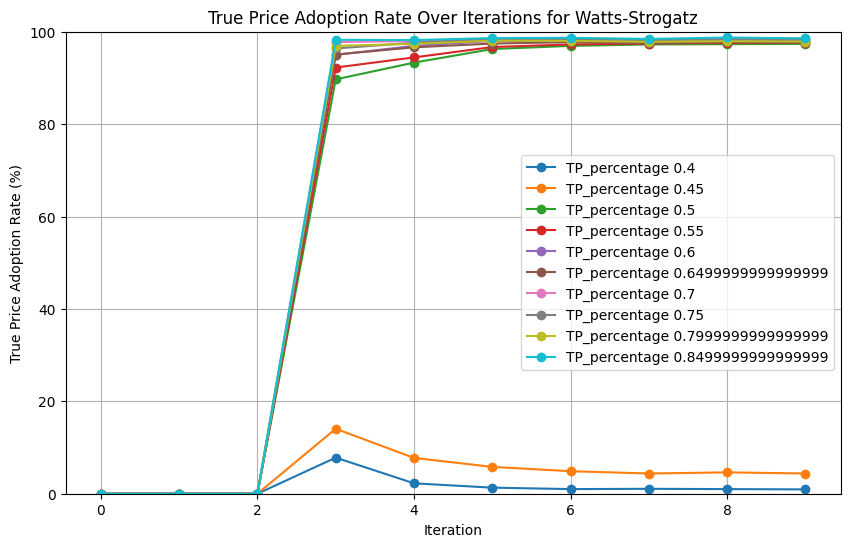

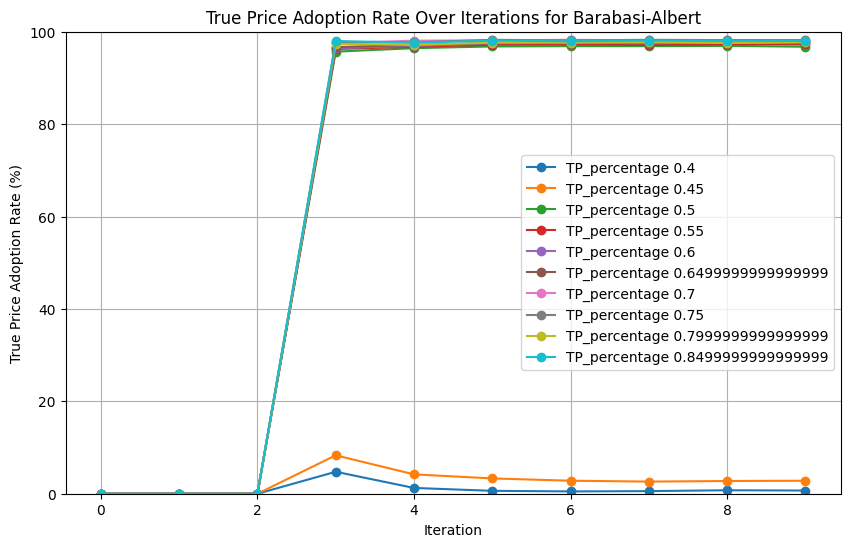

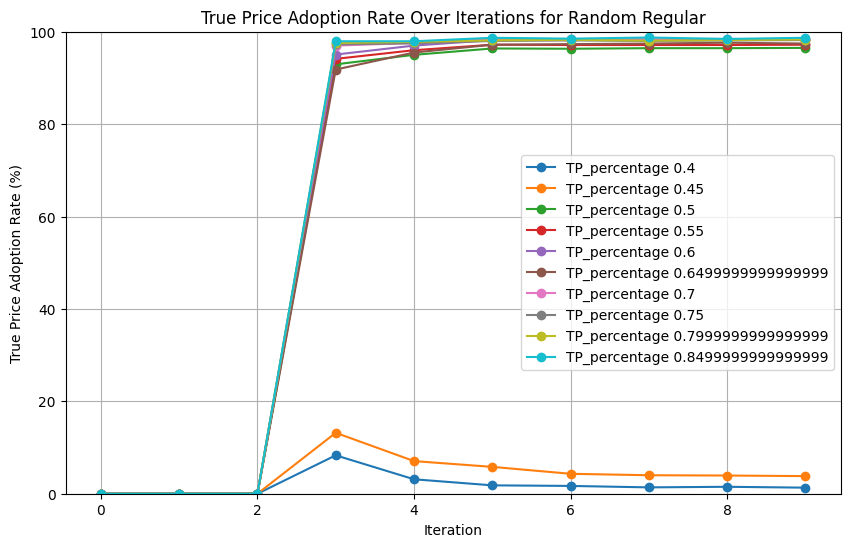

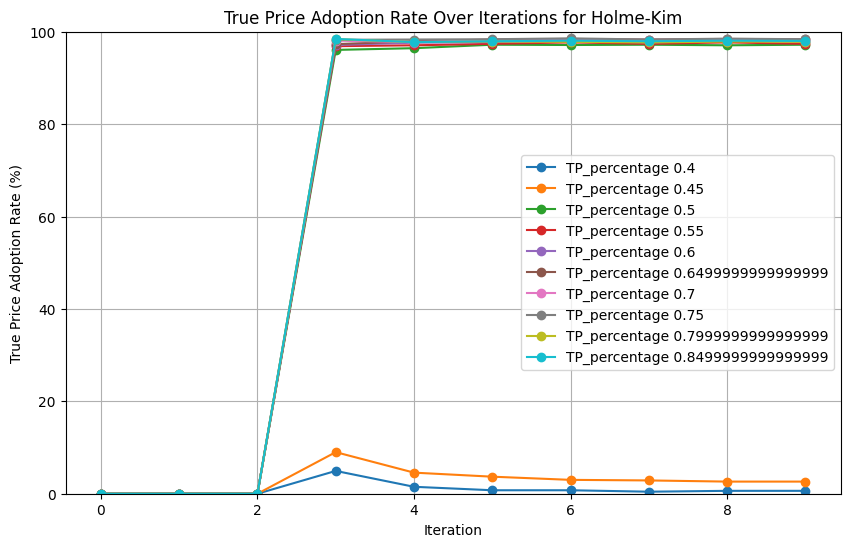

In [7]:
network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

varying_params = {
    'TP_percentage': np.arange(0.4, 0.9, 0.05).tolist(),
}

num_simulations = 1
num_steps = 10

all_configurations = {}
for network_name, net_config in network_configurations.items():
    net_configs = generate_configurations({**base_config, **net_config}, varying_params)
    for idx, config in enumerate(net_configs):
        config_name = f"{network_name}_Config_{idx+1}_TP_{config['TP_percentage']}"
        all_configurations[config_name] = config

results, all_simulation_data = run_all_simulations(all_configurations, num_steps, num_simulations)

plot_adoption_rates(all_simulation_data, varying_params)



## Global Sensitivity Analysis

Sobol indices

Saltelli sampling

Pick key parameters (e.g. alpha, beta, rewiring probability) and key measures (true price adoption rate...)

In [1]:

base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget'],
    'seed': 42,  
    'alpha': 10.0,  
    'beta': 0.5,  
    'homophily_attribute': 'budget' 
}
# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'rewiring_probability': 0.1
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.1
    }
})

network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

network_problems = {
    'Watts-Strogatz': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'k', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1], [0, 10], [0, 1]]
    },
    'Barabasi-Albert': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage', 'max_increase_percentage', 'm', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0, 10], [0, 1]]
    },
    'Random Regular': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage', 'max_increase_percentage', 'd', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0, 10], [0, 1]]
    },
    'Holme-Kim': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20], [2, 10], [0, 1],[0, 10], [0, 1]]
    }
}

num_samples = 256

samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, homophily_attribute, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['homophily_attribute'] = homophily_attribute
    config['alpha'] = params[-4]
    config['beta'] = params[-3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]
    config['epsilon'] = params[3]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, homophily_attribute, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, homophily_attribute, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name} with {homophily_attribute}')
    )
    return np.array(all_results)

num_steps = 10
homophily_attributes = ['budget']

for network_name, config in network_configurations.items():
    for homophily_attribute in homophily_attributes:
        print(f"Running GSA for {network_name} network with {homophily_attribute} attribute...")
        all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], homophily_attribute, num_steps)

        results = {}

        for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
            Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True, conf_level=0.95)
            results[output] = {
                'S1': Si['S1'].tolist(),
                'ST': Si['ST'].tolist(),
                'S2': Si['S2'].tolist(),
                'S1_conf': Si['S1_conf'].tolist(),
                'ST_conf': Si['ST_conf'].tolist()
            }
            print(f'Sensitivity analysis for {output} ({network_name} network, {homophily_attribute} attribute):')
            print(Si)

        with open(f'sensitivity_results_{network_name}_{homophily_attribute}.json', 'w') as f:
            json.dump(results, f)



SyntaxError: invalid syntax (4163257839.py, line 18)

In [12]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
import json

base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['preference_sustainability'],
    'seed': 42,  
    'alpha': 10.0,  
    'beta': 0.5,  
    'homophily_attribute': 'preference_sustainability'  
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'rewiring_probability': 0.1
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.1
    }
})

network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

network_problems = {
    'Watts-Strogatz': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage', 'max_increase_percentage', 'k', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1], [0, 10], [0, 1]]
    },
    'Barabasi-Albert': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage', 'max_increase_percentage', 'm', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0, 10], [0, 1]]
    },
    'Random Regular': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage', 'max_increase_percentage', 'd', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0, 10], [0, 1]]
    },
    'Holme-Kim': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20], [2, 10], [0, 1],[0, 10], [0, 1]]
    }
}

num_samples = 256

samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, homophily_attribute, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['homophily_attribute'] = homophily_attribute
    config['alpha'] = params[-4]
    config['beta'] = params[-3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]
    config['epsilon'] = params[3]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, homophily_attribute, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, homophily_attribute, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name} with {homophily_attribute}')
    )
    return np.array(all_results)

num_steps = 10
homophily_attributes = ['preference_sustainability']

for network_name, config in network_configurations.items():
    for homophily_attribute in homophily_attributes:
        print(f"Running GSA for {network_name} network with {homophily_attribute} attribute...")
        all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], homophily_attribute, num_steps)

        results = {}

        for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
            Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True, conf_level=0.95)
            results[output] = {
                'S1': Si['S1'].tolist(),
                'ST': Si['ST'].tolist(),
                'S2': Si['S2'].tolist(),
                'S1_conf': Si['S1_conf'].tolist(),
                'ST_conf': Si['ST_conf'].tolist()
            }
            print(f'Sensitivity analysis for {output} ({network_name} network, {homophily_attribute} attribute):')
            print(Si)

        with open(f'sensitivity_results_{network_name}_{homophily_attribute}.json', 'w') as f:
            json.dump(results, f)



/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_18388/1175529448.py:106: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


Running GSA for Watts-Strogatz network with preference_sustainability attribute...


KeyboardInterrupt: 

In [13]:


base_config = {
    'TP_percentage': 0.5,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['preference_conformity'],
    'seed': 42,  # Seed for reproducibility
    'alpha': 10.0,  # Exponent in the social attachment equation
    'beta': 0.5,  # Scaling factor for the wealth differences in the social attachment equation
    'homophily_attribute': 'preference_conformity'  # Attribute to use for homophily-based rewiring
}



# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'rewiring_probability': 0.1
    }
})

network_configurations = {
    'Holme-Kim': holme_kim_config
}
network_configs = {
    'Holme-Kim': holme_kim_config
}

# Define the model inputs for each network type
network_problems = {
    'Holme-Kim': {
        'num_vars': 10,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon', 'min_increase_percentage', 'max_increase_percentage', 'm', 'p', 'alpha', 'beta'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20], [2, 10], [0, 1],[0, 10], [0, 1]]
    }
}

# Number of samples
num_samples = 256

# Generate samples for each network problem
samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)

# Function to collect data from the model
def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, homophily_attribute, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['homophily_attribute'] = homophily_attribute
    config['alpha'] = params[-4]
    config['beta'] = params[-3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]
    config['epsilon'] = params[3]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, homophily_attribute, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, homophily_attribute, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name} with {homophily_attribute}')
    )
    return np.array(all_results)

num_steps = 10
homophily_attributes = ['preference_conformity']

# Run GSA for each network and each homophily attribute
for network_name, config in network_configurations.items():
    for homophily_attribute in homophily_attributes:
        print(f"Running GSA for {network_name} network with {homophily_attribute} attribute...")
        all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], homophily_attribute, num_steps)

        results = {}

        # Perform Sobol sensitivity analysis with confidence intervals
        for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
            Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True, conf_level=0.95)
            results[output] = {
                'S1': Si['S1'].tolist(),
                'ST': Si['ST'].tolist(),
                'S2': Si['S2'].tolist(),
                'S1_conf': Si['S1_conf'].tolist(),
                'ST_conf': Si['ST_conf'].tolist()
            }
            print(f'Sensitivity analysis for {output} ({network_name} network, {homophily_attribute} attribute):')
            print(Si)

        # Save results to a JSON file
        with open(f'sensitivity_results_{network_name}_{homophily_attribute}.json', 'w') as f:
            json.dump(results, f)



/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_18388/1627633087.py:61: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


Running GSA for Holme-Kim network with preference_conformity attribute...


KeyboardInterrupt: 